# Safety levels

NEN 8700 specifies a number of safety levels, which are essentially reliability indices that a construction must meet:

| Safety level | Assessment level |
|--------------|------------------|
| CC3          | 3.3              |
| CC2          | 2.5              |
| CC1b         | 1.8              |
| CC1a         | 1.8              |


In this example, we will show how to apply the safety levels to assess the bearing capacity of a pile. 

### Define model

First, let's import the necessary packages:

In [1]:
from probabilistic_library import SensitivityProject, DistributionType, SensitivityMethod, StandardNormal
import numpy as np
import matplotlib.pyplot as plt

We use the Koppejan method to calculate the bearing capacity of a pile ($p$).

For this example, we assume there are two soil layers: the top layer is clay, and the bottom layer is sand. The surface level is at 0 m+NAP. The soil has the following characteristics:

| Parameter | Description                          |
|-----------|--------------------------------------|
| z         | Depth at which the sand layer starts |
| q_clay    | CPT resistance in clay layer         |
| q_sand    | CPT resistance in sand layer         |
    
The pile has the following characteristics:

| Parameter | Description         |
|-----------|---------------------|
| D         | Diameter of the pile|
| L         | Length of the pile  |

The Koppejan method is implemented in the following function:

In [2]:
def get_bearing_capacity(z, q_clay, q_sand, D, L):
    A = 0.25 * np.pi * D**2     
    L_clay = min(L, z)
    L_sand = max(0, L - z)

    q_i = q_sand if L > z else q_sand * ((z-L) / 0.7 * A) + q_clay * (1 - (z-L)/0.7 * A)
    q_ii = q_i
    q_iii = q_sand if L_sand > 8 * A else q_sand * (L_sand/8 * A) + q_clay * (1 - L_sand/(8 * A))
    q_tip = 0.25 * q_i + 0.25 * q_ii + 0.5 * q_iii

    p_tip = A * q_tip
    p_shaft = np.pi * D * (q_clay * L_clay + q_sand * L_sand)

    p = p_tip + p_shaft
    
    return p

The bearing capacity of a pile is compared with the applied load, resulting in a unity check value (UC). A UC value greater than $1.0$ indicates failure, meaning the load exceeds the bearing capacity of the pile.

In [3]:
def get_unity_check(load, z, q_clay, q_sand, D, L):
    p = get_bearing_capacity(z, q_clay, q_sand, D, L)
    uc = load / p

    return uc

### Sensitivity analysis

The goal is to calculate the UC values at the safety levels. To achieve this, we conduct a sensitivity analysis. We begin by creating a sensitivity project and defining the model:

In [4]:
project = SensitivityProject()
project.model = get_unity_check

print("Available variables:")
for var in project.variables:
    print(var.name)

Available variables:
load
z
q_clay
q_sand
D
L


### Assign stochastic values

The following values and uncertainties are applied to the variables. The load is derived from a design value and is recalculated as a stochastic variable, as we want to perform a full probabilistic calculation.

In [5]:
project.variables["D"].distribution = DistributionType.normal
project.variables["D"].mean = 0.2
project.variables["D"].deviation = 0.04
project.variables["D"].truncated = True
project.variables["D"].minimum = 0.0
project.variables["D"].maximum = 1.0

project.variables["L"].distribution = DistributionType.normal
project.variables["L"].mean = 12.0
project.variables["L"].deviation = 0.8

project.variables["z"].distribution = DistributionType.normal
project.variables["z"].mean = 10.0
project.variables["z"].deviation = 0.2

project.variables["q_sand"].distribution = DistributionType.log_normal
project.variables["q_sand"].mean = 500.0
project.variables["q_sand"].deviation = 50.0

project.variables["q_clay"].distribution = DistributionType.log_normal
project.variables["q_clay"].mean = 25000.0
project.variables["q_clay"].deviation = 400.0

project.variables["load"].distribution = DistributionType.gumbel
project.variables["load"].design_quantile = 0.95
project.variables["load"].design_factor = 1.0
project.variables["load"].variation = 0.1
project.variables["load"].design_value = 100000.0

print(f"Load = {project.variables["load"].mean} +- {project.variables["load"].deviation}")

Load = 84275.78591160773 +- 8427.578591160775


### Perform calculation 

We peform the sensitivity analysis using `crude_monte_carlo` method:

In [6]:
project.settings.sensitivity_method = SensitivityMethod.crude_monte_carlo
project.settings.maximum_samples = 10000
project.run()
uc_mc = project.stochast

Let's plot the results:

Text(0.5, 1.0, 'crude_monte_carlo')

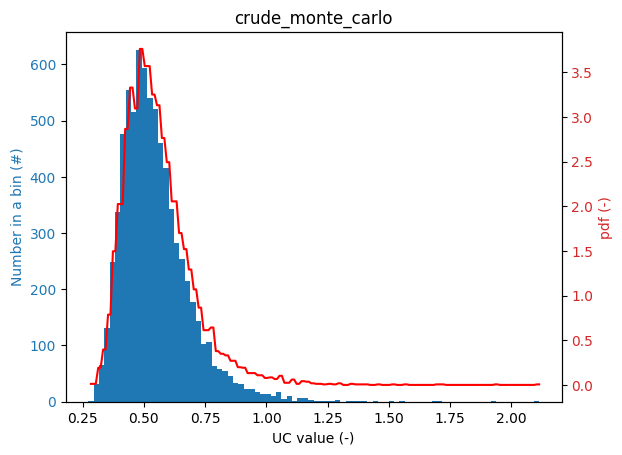

In [7]:
bin_start = [uc_mc.histogram_values[ii].lower_bound for ii in range(0, len(uc_mc.histogram_values))]
bin_end = [uc_mc.histogram_values[ii].upper_bound for ii in range(0, len(uc_mc.histogram_values))]
amount = [uc_mc.histogram_values[ii].amount for ii in range(0, len(uc_mc.histogram_values))]

pdf_grid = np.arange(min(bin_start), max(bin_end), 0.01)
pdf = [uc_mc.get_pdf(val) for val in pdf_grid]

fig, ax1 = plt.subplots()
color = "tab:blue"
ax1.set_xlabel("UC value (-)")
ax1.set_ylabel("Number in a bin (#)", color=color)
ax1.bar(bin_start, amount, width=(np.array(bin_end)-np.array(bin_start)), label=var)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("pdf (-)", color=color)
ax2.plot(pdf_grid, pdf, "r", label="pdf")
ax2.tick_params(axis="y", labelcolor=color)
plt.title(project.settings.sensitivity_method)

Next, we derive the values of UC, which correspond to the predefined safety levels. If the UC value for a given safety level is greater than $1.0$, then that safety level is not met.

In [8]:
safety_levels = [1.8, 2.5, 3.3]
safety_levels_txt = ["CC1b", "CC2 ", "CC3 "]

def check_sl(uc, safety_levels, safety_levels_txt):

    for idx, sl in enumerate(safety_levels):
        p = StandardNormal.get_p_from_u(sl)
        uc_sl = uc.get_quantile(p)
        print (f"Safety level ({safety_levels_txt[idx]}):  {sl} => UC = {uc_sl}")

check_sl(uc_mc, safety_levels, safety_levels_txt)

Safety level (CC1b):  1.8 => UC = 0.8564457238247961
Safety level (CC2 ):  2.5 => UC = 1.0979807121952414
Safety level (CC3 ):  3.3 => UC = 1.6925889446516011



We see that the pile construction meets only the safety level CC1b. Safety levels CC2 and CC3 are not met.

### Alternative methods

We can also apply other sensitivity methods e.g. `form`, `importance_sampling` and `directional_sampling`. 
For `directional_sampling`, it is neceessary to predefine the quantiles in which we are interested (the reliability inde 3.3 is not calculated well, therefore another value is used and extrapoloated for 3.3)

In [9]:
project.settings.sensitivity_method = SensitivityMethod.form
project.run()
uc_form = project.stochast
print(project.settings.sensitivity_method)
check_sl(uc_form, safety_levels, safety_levels_txt)

project.settings.sensitivity_method = SensitivityMethod.importance_sampling
project.settings.maximum_samples = 1000
project.settings.stochast_settings["D"].start_value = -0.5
project.settings.stochast_settings["load"].start_value = 0.5
project.run()
uc_is = project.stochast
print(' ')
print(project.settings.sensitivity_method)
check_sl(uc_is, safety_levels, safety_levels_txt)

project.settings.sensitivity_method = SensitivityMethod.directional_sampling
project.settings.maximum_directions = 1000
project.settings.variation_coefficient = 0.01
project.settings.quantiles.append(StandardNormal.get_p_from_u(1.8))
project.settings.quantiles.append(StandardNormal.get_p_from_u(2.5))
project.settings.quantiles.append(StandardNormal.get_p_from_u(3.0))

project.run()
uc_ds = project.stochast
print(' ')
print(project.settings.sensitivity_method)
check_sl(uc_ds, safety_levels, safety_levels_txt)

form
Safety level (CC1b):  1.8 => UC = 0.8486364455633592
Safety level (CC2 ):  2.5 => UC = 1.0785665015103125
Safety level (CC3 ):  3.3 => UC = 1.5679541915977104
 
importance_sampling
Safety level (CC1b):  1.8 => UC = 0.840942925401619
Safety level (CC2 ):  2.5 => UC = 1.0833103483499738
Safety level (CC3 ):  3.3 => UC = 1.5372973780546944
 
directional_sampling
Safety level (CC1b):  1.8 => UC = 0.8537128868245834
Safety level (CC2 ):  2.5 => UC = 1.0859117555680067
Safety level (CC3 ):  3.3 => UC = 1.4267743659936905
